## Goal of the Competition
The goal of this competition is to predict if a person has any of three medical conditions. You are being asked to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). You will create a model trained on measurements of health characteristics.

To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

Your work will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

## Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

### Files and Field Descriptions
**train.csv** - The training set.
- `Id` Unique identifier for each observation.
- `AB`-`GL` Fifty-six anonymized health characteristics. All are numeric except for `EJ`, which is categorical.
- `Class` A binary target: `1` indicates the subject has been diagnosed with one of the three conditions, `0` indicates they have not.

**test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.

**greeks.csv** - Supplemental metadata, only available for the training set.
- `Alpha` Identifies the type of age-related condition, if present.
- `A` No age-related condition. Corresponds to class `0`.
- `B`, `D`, `G` The three age-related conditions. Correspond to class `1`.
- `Beta`, `Gamma`, `Delta` Three experimental characteristics.
- `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page for more details.

### Import libs

In [2]:
!pip install rogeriopradoj-paretochart

  Preparing metadata (setup.py) ... done
  Created wheel for rogeriopradoj-paretochart: filename=rogeriopradoj_paretochart-2.0.0-py3-none-any.whl size=6376 sha256=e3733bd96b8d47a2eb5243d5d04f3e1a815a706811ab4393744a68ef79d04c32
  Stored in directory: /root/.cache/pip/wheels/18/7a/be/b22ee0e7ed314b68674c6602d2c0a897a1cdb06df22232bd16
Successfully built rogeriopradoj-paretochart


In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt, floor
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from paretochart import pareto
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    RocCurveDisplay)
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

# Random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Functions definitions

In [4]:
def pie_label(pct, data):
    '''
    Adds the absolute value to the pie chart
    '''
    absolute = round((pct / 100) * len(data))
    return f"{pct:.1f}%\n({absolute})"

def prepare_plot_fig(plots, n_cols = None, d_type = 'num', title = None):
    """Prepare the figure for plotting"""
    if n_cols is None:
        ncols = min(5, ceil(sqrt(len(plots))))
    else:
        ncols = n_cols
    nrows = ceil(len(plots) / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), layout='constrained')
    if type(axs) == np.ndarray:
        axs = axs.flatten()
    if title is None:
        title = 'Numerical Columns' if d_type == 'num' else 'Categorical & Binary Columns'
    fig.suptitle(title, fontsize=max(ncols * 4, 16), fontweight='bold')

    return nrows, ncols, fig, axs

def plot_distributions(df, bins = 30, kde = True, hue = None, n_cols = None):
    """Plot the distributions of numerical and categorical columns"""

    # Separate columns by type
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    num_cols = df.select_dtypes(include='number').columns
    for col in num_cols:
        if len(df[col].unique()) == 2:
            cat_cols = cat_cols.append(pd.Index([col]))
            num_cols = num_cols.drop(col)
    
    # Plot numerical columns
    if len(num_cols) > 0:
        nrows, ncols, fig, axs = prepare_plot_fig(num_cols, d_type='num', n_cols=n_cols)

        for i, col in enumerate(num_cols, start=1):
            plt.subplot(nrows, ncols, i)
            ax = sns.histplot(x=col, data=df, bins=bins, kde=kde, hue=hue if col != hue else None)
            height = max([p.get_height() for p in ax.patches]) * 1.05
            ax.set_ylim(0,height)
            ax.set(ylabel='', xlabel='')
            plt.title(col, fontsize=max(ncols * 2, 10), fontweight='bold')
        plt.show()

    # Plot categorical columns
    if len(cat_cols) > 0:
        nrows, ncols, fig, axs = prepare_plot_fig(cat_cols, d_type='cat', n_cols=n_cols)

        for i, col in enumerate(cat_cols, start=1):
            plt.subplot(nrows, ncols, i)
            ax = sns.countplot(x=col, data=df, hue=hue if col != hue else None)
            ax.set(ylabel='', xlabel='')
            plt.title(col, fontsize=max(ncols * 2, 10), fontweight='bold')
        plt.show()

def boxplot_grid(df, hue = None, n_cols = None):
    """Plot the boxplots of numerical columns"""

    cols = df.select_dtypes(include='number').columns.drop(hue, errors='ignore')
    nrows, ncols, fig, axs = prepare_plot_fig(cols, n_cols=n_cols)

    for i, col in enumerate(cols, start=1):
        plt.subplot(nrows, ncols, i)
        ax = sns.boxplot(y=col, x=hue, data=df)
        ax.set(ylabel='', xlabel='')
        plt.title(col, fontsize=max(ncols * 2, 10), fontweight='bold')
    plt.show()

def scatterplot_high_corr(df, threshold = 0.5, hue = None, n_cols = None, **kwargs):
    """Plot the scatterplots of highly correlated numerical columns"""

    cols = df.select_dtypes(include='number').columns.drop(hue, errors='ignore')

    plots = []
    for x in cols:
        for y in cols:
            if x != y:
                pearson = df[x].corr(df[y])
                if abs(pearson) > threshold:
                    plots.append((x, y, pearson))
        cols = cols.drop(x)

    title = f'Highly Correlated Columns (Pearson > {threshold})'
    nrows, ncols, fig, axs = prepare_plot_fig(plots, n_cols=n_cols, title=title)
    for i, (x, y, p) in enumerate(plots, start=1):
        plt.subplot(nrows, ncols, i)
        sns.scatterplot(x=x, y=y, data=df, hue=hue, **kwargs)
        plt.title(f'{x.upper()} vs {y.upper()} ({p :.2f})', fontsize=max(ncols * 2, 10), fontweight='bold')

## Data Understanding

In [5]:
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
sample_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [6]:
# Visualize data sets
print('*' * 30, 'TEST DATA SET SAMPLE', '*' * 30)
display(test)
print('*' * 30, 'TRAIN DATA SET', '*' * 30)
display(train.head())
print(train.shape)
print('*' * 30, 'GREEKS DATA SET', '*' * 30)
display(greeks.head())
print(greeks.shape)

****************************** TEST DATA SET SAMPLE ******************************


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


****************************** TRAIN DATA SET ******************************


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


(617, 58)
****************************** GREEKS DATA SET ******************************


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


(617, 6)


### Data Visualization

In [7]:
# # Visualize distributions
# plot_distributions(train.drop(columns='Id'), hue='Class')

In [8]:
# plot_distributions(greeks.drop(columns=['Id', 'Epsilon']), hue='Alpha')

In [9]:
# # Visualize Outliers
# boxplot_grid(train, hue='Class')

In [10]:
# # Visualize correlations
# plt.figure(figsize=(30, 30))
# sns.heatmap(train.corr(numeric_only=True), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm');

In [11]:
# scatterplot_high_corr(train.drop(columns='Id'), threshold=0.7, hue='Class', alpha=0.5)

In [12]:
# train.plot.scatter(x='AR', y='EB', c='Class', colormap='coolwarm', alpha=0.5)
# print('Pearson:', train['AR'].corr(train['EB']))

In [13]:
# t = train[['AR', 'EB', 'Class']][train['AR'] < 150]
# t.plot.scatter(x='AR', y='EB', c='Class', colormap='coolwarm', alpha=0.5)
# print('Pearson:', t['AR'].corr(t['EB']))

## Data Preparation

### Missing Values and Duplicates

In [14]:
# Check for missing values
print('*' * 30, 'MISSING VALUES', '*' * 30, end='\n\n')
test_missing = round((test.isnull().sum() / len(test)) * 100, 2)
print('Test data set missing percentage: ', test_missing[test_missing > 0], sep='\n', end='\n\n')

train_missing = round((train.isnull().sum() / len(train)) * 100, 2)
print('Train data set missing percentage: ', train_missing[train_missing > 0], sep='\n', end='\n\n')

greeks_missing = round((greeks.isnull().sum() / len(greeks)) * 100, 2)
print('Greeks data set missing percentage: ', greeks_missing[greeks_missing > 0], sep='\n', end='\n\n')

# Check for duplicates
print('*' * 30, 'DUPLICATES', '*' * 30, end='\n\n')
print('Test data set: ', test.duplicated().sum())
print('Train data set: ', train.duplicated().sum())
print('Greeks data set: ', greeks.duplicated().sum())

****************************** MISSING VALUES ******************************

Test data set missing percentage: 
Series([], dtype: float64)

Train data set missing percentage: 
BQ    9.72
CB    0.32
CC    0.49
DU    0.16
EL    9.72
FC    0.16
FL    0.16
FS    0.32
GL    0.16
dtype: float64

Greeks data set missing percentage: 
Series([], dtype: float64)

****************************** DUPLICATES ******************************

Test data set:  0
Train data set:  0
Greeks data set:  0


In [15]:
# Result of dropping rows with missing values
train_drop_rows = train.dropna()
print('Train data set shape after dropping rows with missing values:', train_drop_rows.shape)
print('Number of rows dropped:', train.shape[0] - train_drop_rows.shape[0], 
      f'({round(((train.shape[0] - train_drop_rows.shape[0]) / train.shape[0]) * 100, 2)}% of the original data set)', end='\n\n')

# Result of dropping colums with missing values
train_drop_cols = train.dropna(axis=1)
print('Train data set shape after dropping columns with missing values:', train_drop_cols.shape)
print('Number of columns dropped:', train.shape[1] - train_drop_cols.shape[1],
      f'({((train.shape[1] - train_drop_cols.shape[1]) / train.shape[1]) * 100 :.2f}% of the original data set)', end='\n\n')

Train data set shape after dropping rows with missing values: (548, 58)
Number of rows dropped: 69 (11.18% of the original data set)

Train data set shape after dropping columns with missing values: (617, 49)
Number of columns dropped: 9 (15.52% of the original data set)



In [16]:
# Remove rows with less than 1% missing values
missing_cols = train_missing[train_missing > 0].index.tolist()
missing_cols.append('Class')
missing_cols.remove('BQ')
missing_cols.remove('EL')
train[missing_cols][train[missing_cols].isnull().any(axis=1)]

,CB,CC,DU,FC,FL,FS,GL,Class
24,NaN,NaN,0.005518,117.815712,0.173229,0.433472,21.978000,0
114,NaN,NaN,0.005518,22.379616,0.173229,0.067730,21.978000,0
330,536.221322,NaN,0.005518,NaN,0.173229,NaN,21.978000,1
562,15.165150,0.899028,0.558657,54.429648,95.038650,NaN,0.007333,0
594,27.609764,0.761854,NaN,32.187120,NaN,0.731484,NaN,0


In [17]:
# Get indexes of rows with missing values and drop them from train and greeks data sets
idx_missing = train[missing_cols][train[missing_cols].isnull().any(axis=1)].index
train = train.drop(idx_missing, axis=0).reset_index(drop=True)
greeks = greeks.drop(idx_missing, axis=0).reset_index(drop=True)
print(train.shape)
print(greeks.shape)

(612, 58)
(612, 6)


#### KNN Imputer

In [18]:
# knn = KNNImputer(n_neighbors=5)
# knn_imp = pd.DataFrame(knn.fit_transform(train.drop(columns=['Id', 'EJ'])), columns=knn.feature_names_in_)
# knn_imp

In [19]:
# # Plot distributions of imputed and original values
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Imputation using KNN Imputer (k=5)', fontweight='bold', fontsize=18)

# sns.histplot(knn_imp['BQ'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[0])
# sns.histplot(train['BQ'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[0])
# axs[0].set_title('BQ', fontweight='bold')
# axs[0].legend()

# sns.histplot(knn_imp['EL'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[1])
# sns.histplot(train['EL'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[1])
# axs[1].set_title('EL', fontweight='bold')
# axs[1].legend();

#### Iterative Imputer

In [20]:
# ii = IterativeImputer(max_iter=100, random_state=random_state)
# ii_imp = pd.DataFrame(ii.fit_transform(train.drop(columns=['Id', 'EJ'])), columns=ii.feature_names_in_)
# ii_imp

In [21]:
# # Plot distributions of imputed and original values
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Imputation using Iterative Imputer', fontweight='bold', fontsize=18)

# sns.histplot(ii_imp['BQ'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[0])
# sns.histplot(train['BQ'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[0])
# axs[0].set_title('BQ', fontweight='bold')
# axs[0].legend()

# sns.histplot(ii_imp['EL'], bins=10, alpha=0.5, label='Imputed', kde=True, ax=axs[1])
# sns.histplot(train['EL'], bins=10, alpha=0.5, label='Original', kde=True, ax=axs[1])
# axs[1].set_title('EL', fontweight='bold')
# axs[1].legend();

### Drop ID Column

In [22]:
train = train.drop(columns='Id')
test = test.drop(columns='Id')
greeks = greeks.drop(columns='Id')

### Split Train and Test data sets

In [23]:
# Define features and target
X = train.drop(columns='Class')
y = train['Class']

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

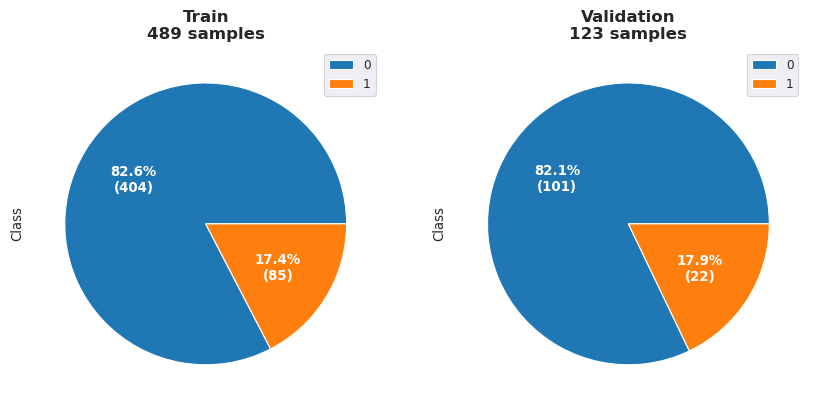

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train set target distribution
y_train.value_counts().plot.pie(autopct=lambda pct: pie_label(pct, y_train), ax=axs[0], textprops={'color' : "w", 'fontweight' : 'bold'})
axs[0].set_title(f'Train\n{len(y_train)} samples', fontdict={'fontsize' : '12', 'fontweight': 'bold'})
axs[0].legend()

# Plot validation set target distribution
y_val.value_counts().plot.pie(autopct=lambda pct: pie_label(pct, y_val), ax=axs[1], textprops={'color' : "w", 'fontweight' : 'bold'})
axs[1].set_title(f'Validation\n{len(y_val)} samples', fontdict={'fontsize' : '12', 'fontweight': 'bold'})
axs[1].legend();

### Encode Categorical Variable

In [25]:
# Ecoding categorical features
le = LabelEncoder()
X_train['EJ'] = le.fit_transform(X_train['EJ'])
X_val['EJ'] = le.transform(X_val['EJ'])
test['EJ'] = le.transform(test['EJ'])

In [26]:
list(le.classes_)

['A', 'B']

### Impute Missing Variables with KNN Imputer

In [27]:
# Impute missing values using KNN Imputer (k=5)
knn = KNNImputer(n_neighbors=5)
X_train_imp = pd.DataFrame(knn.fit_transform(X_train), columns=knn.feature_names_in_, index=X_train.index)
X_val_imp = pd.DataFrame(knn.transform(X_val), columns=knn.feature_names_in_, index=X_val.index)

# Recheck for missing values
print('Number of missing values in train set:', X_train_imp.isnull().sum().sum())
print('Number of missing values in validation set:', X_val_imp.isnull().sum().sum())

Number of missing values in train set: 0
Number of missing values in validation set: 0


### Handle Outliers

In [28]:
def remove_outliers(X, y, random_state=random_state):
    out = IsolationForest(random_state=random_state)
    out_pred = out.fit_predict(X)
    X = X[out_pred == 1]
    y = y.loc[X.index]
    return X, y

In [29]:
out = IsolationForest(random_state=random_state)
out_pred = out.fit_predict(X_train_imp)
outliers = X_train_imp.copy()
outliers['outlier'] = out_pred
outliers['outlier'] = outliers['outlier'].map({1: 0, -1: 1})
outliers['Class'] = y_train

print('Number of outliers in train set:', outliers['outlier'].sum())

Number of outliers in train set: 10


In [30]:
# scatterplot_high_corr(outliers, threshold=0.7, hue='outlier', style='Class', alpha=0.5, palette=['r', 'b'], n_cols=5)

In [31]:
# scatterplot_high_corr(outliers[outliers['outlier'] == 0], threshold=0.7, hue='outlier', style='Class', alpha=0.5, palette=['r'], n_cols=5)

In [32]:
# plt.figure(figsize=(30, 30))
# sns.heatmap(outliers[outliers['outlier'] == 0].drop(columns='outlier').corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1);

In [33]:
outliers[outliers['outlier'] == 1].index

Int64Index([10, 51, 508, 384, 523, 230, 375, 581, 182, 353], dtype='int64')

In [34]:
# Remove outliers from train set
X_train = X_train.loc[outliers[outliers['outlier'] == 0].index]
y_train = y_train.loc[outliers[outliers['outlier'] == 0].index]

# Remove outliers from imputed train set
X_train_imp = X_train_imp.loc[outliers[outliers['outlier'] == 0].index]

### Normalize and Standardize

In [35]:
# # Define transformer objects
# ss = StandardScaler()
# pt = PowerTransformer()
# qt = QuantileTransformer(output_distribution='normal', random_state=random_state)

# # Transform data
# log_df = np.log(X_train_imp.drop(columns='EJ'))
# ss_df = pd.DataFrame(ss.fit_transform(X_train_imp.drop(columns='EJ')), columns=ss.feature_names_in_)
# pt_df = pd.DataFrame(pt.fit_transform(X_train_imp.drop(columns='EJ')), columns=pt.feature_names_in_)
# qt_df = pd.DataFrame(qt.fit_transform(X_train_imp.drop(columns='EJ')), columns=qt.feature_names_in_)

# # Visualize distribution of features after transformation
# fig, axs = plt.subplots(11, 5, figsize=(18, 30), layout='constrained')
# sns.set_palette('tab10')

# for i, col in enumerate(ss_df.columns, start=1):
#     plt.subplot(11, 5, i)
#     sns.histplot(x=log_df[col], bins=20, kde=True, alpha=0.3, label='Log')
#     sns.histplot(x=ss_df[col], bins=20, kde=True, alpha=0.3, label='SS')
#     sns.histplot(x=pt_df[col], bins=20, kde=True, alpha=0.3, label='PT')
#     sns.histplot(x=qt_df[col], bins=20, kde=True, alpha=0.3, label='QT')
#     plt.legend()
#     plt.xlabel('')
#     plt.title(col, fontsize=12)

In [36]:
# PowerTransformer seem to perform best
pt = PowerTransformer()
X_train_scaled = pd.DataFrame(pt.fit_transform(X_train_imp.drop(columns='EJ')), columns=pt.feature_names_in_, index=X_train_imp.index)
X_train_scaled['EJ'] = X_train_imp['EJ']

# Transform validation set
X_val_scaled = pd.DataFrame(pt.transform(X_val_imp.drop(columns='EJ')), columns=pt.feature_names_in_, index=X_val_imp.index)
X_val_scaled['EJ'] = X_val['EJ']

### Principal Component Analysis (PCA)

/opt/conda/lib/python3.10/site-packages/paretochart/paretochart.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yt)


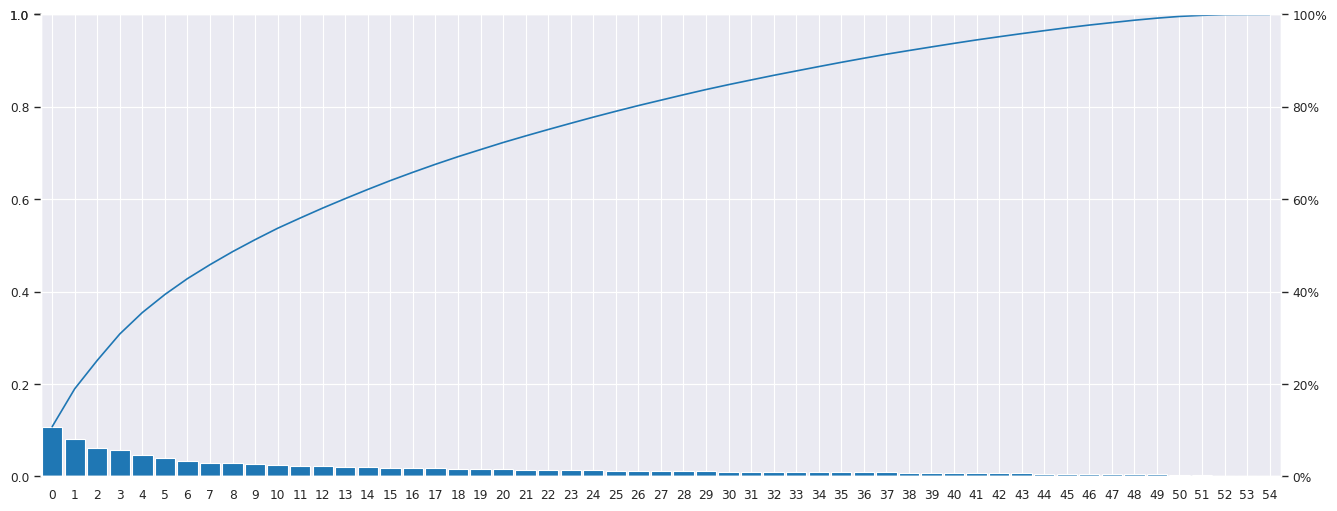

1 components: 10.78%
2 components: 18.98%
3 components: 25.13%
4 components: 30.85%
5 components: 35.49%
6 components: 39.39%
7 components: 42.82%
8 components: 45.84%
9 components: 48.66%
10 components: 51.26%
11 components: 53.72%
12 components: 55.94%
13 components: 58.1%
14 components: 60.15%
15 components: 62.13%
16 components: 64.04%
17 components: 65.84%
18 components: 67.57%
19 components: 69.22%
20 components: 70.75%
21 components: 72.28%
22 components: 73.71%
23 components: 75.1%
24 components: 76.45%
25 components: 77.77%
26 components: 79.04%
27 components: 80.28%
28 components: 81.45%
29 components: 82.62%
30 components: 83.75%
31 components: 84.81%
32 components: 85.82%
33 components: 86.82%
34 components: 87.77%
35 components: 88.72%
36 components: 89.64%
37 components: 90.53%
38 components: 91.39%
39 components: 92.19%
40 components: 92.97%
41 components: 93.75%
42 components: 94.49%
43 components: 95.18%
44 components: 95.85%
45 components: 96.49%
46 components: 97.13%

In [37]:
# Fit PCA
pca = PCA(n_components=len(X_train_scaled.columns), random_state=random_state)
pca.fit(X_train_scaled)

# Visualize explained variance ratio
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pareto(pca.explained_variance_ratio_)
plt.show()

# Calculate cumulative explained variance
explained_variances = (pca.explained_variance_ratio_.cumsum() * 100).round(2)
for c, i in enumerate(explained_variances, start=1):
    print(f'{c} components: {i}%')

In [38]:
def find_n_components(cumulative_variance, threshold = 80):
    for i, variance in enumerate(cumulative_variance):
        if variance >= threshold:
            return i + 1

In [39]:
# Transform data set with PCA
n_components = find_n_components(explained_variances, 80)
pca = PCA(n_components=n_components, random_state=random_state)

pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Create data frames
component_names = [f"PC{i+1}" for i in range(pca.components_.shape[0])]
X_train_pca = pd.DataFrame(X_train_pca, columns=component_names, index=X_train_scaled.index)
X_val_pca = pd.DataFrame(X_val_pca, columns=component_names, index=X_val_scaled.index)

In [40]:
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
96,2.408857,1.473371,-0.438248,0.636048,-1.774286,-0.419972,0.730787,-0.005950,0.622183,1.173384,...,-0.008228,-0.512852,-0.497873,0.747334,-0.783136,-0.366072,0.283163,0.748214,1.028036,-0.833354
19,-4.197076,-2.453095,-0.400273,0.009431,-0.275043,1.447799,-2.021252,-2.719613,-0.188416,1.583616,...,-1.157368,0.627306,-0.942502,0.056475,-1.541266,0.667655,0.148749,-0.195254,0.217851,-1.004859
32,-0.311748,0.525230,-4.473864,0.865027,-1.465576,0.237913,-0.015749,0.090178,2.434347,1.847770,...,0.202130,1.891447,-0.495833,-0.790224,1.090386,0.382565,-0.674069,-1.305864,-1.565481,0.840438
576,-0.080492,1.199788,-0.001803,0.166415,1.027637,-0.592893,5.089988,1.833202,-3.434161,0.830248,...,0.020764,-0.600782,-0.056259,2.896401,1.788535,0.437050,-0.031374,0.340165,1.462672,1.064201
322,-1.178078,2.904470,-0.237332,1.833037,3.361865,0.540519,-2.257654,-1.051241,0.287382,0.951533,...,0.678903,-1.283475,-1.308222,-1.442629,0.995365,0.066876,-0.030389,1.620554,0.025252,1.032083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0.031785,-3.432276,-3.937763,0.088667,-1.789952,0.101153,1.077779,-0.025756,-0.415583,0.398498,...,-0.760261,-0.390689,-0.131427,1.885258,-0.126570,-0.127332,-0.477507,0.567509,0.833604,0.078460
306,-1.917737,3.454364,1.167619,-0.741706,-0.741395,-0.080656,-1.473586,2.362190,-2.624864,-0.884116,...,-1.709371,-0.000279,1.210530,-0.066515,0.154546,0.395726,0.413073,-0.093642,-0.607783,0.111579
287,-0.257550,-3.470048,-1.223114,0.345592,1.158532,-1.394924,-1.183032,0.572193,-0.251992,0.260849,...,0.484265,-0.793343,1.737970,-1.164488,-0.563476,-0.968334,0.469037,-0.205960,-0.626416,0.020962
338,1.215666,-2.394836,-0.327921,0.466687,1.200863,1.330035,-0.473399,0.587483,-1.301935,-0.043981,...,-0.272994,1.211535,1.390632,-1.045628,0.214394,1.601847,0.216711,-1.164173,0.059801,-1.401720


In [41]:
# # Visualize components in 2D
# sns.scatterplot(x='PC1', y='PC2', data=X_train_pca, hue=y_train, palette=['r', 'b'], alpha=0.8);

## Modeling

### Define balanced log loss score

Submissions are evaluated using a balanced logarithmic loss. The overall effect is such that each class is roughly equally important for the final score.

Each observation is either of class 0 or of class 1. For each observation, you must submit a probability for each class. The formula is then:

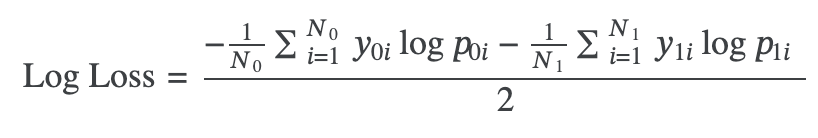

where (N_{c}) is the number of observations of class (c), (\log) is the natural logarithm, (y_{c i}) is 1 if observation (i) belongs to class (c) and 0 otherwise, (p_{c i}) is the predicted probability that observation (i) belongs to class (c).

The submitted probabilities for a given row are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, each predicted probability 𝑝
 is replaced with max(min(𝑝,1−10−15),10−15).

In [42]:
def balanced_logloss(y_true, y_pred):
    """
    Calculates balanced logloss.
    """
    if len(y_pred.shape) == 1 or (len(y_pred.shape) == 2 and y_pred.shape[-1] == 1):
        y_pred = np.hstack((1 - y_pred, y_pred))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred = y_pred / y_pred.sum(axis=1)[:, None]
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

    nc = np.bincount(y_true)

    w_0 = np.array([1 if i == 0 else 0 for i in y_true])
    w_1 = np.array([1 if i == 1 else 0 for i in y_true])
    
    if nc[0] > 0:
        log_loss_0 = - (1 * np.sum(w_0 * np.log(y_pred[:, 0]))) / nc[0]
    else:
        log_loss_0 = 0
    if nc[1] > 0:
        log_loss_1 = - (1 * np.sum(w_1 * np.log(y_pred[:, 1]))) / nc[1]
    else:
        log_loss_1 = 0
        
    balanced_logloss = (log_loss_0 + log_loss_1) / 2
    return balanced_logloss


In [43]:
def balanced_logloss_val(y_true, y_pred):
    """
    Calculates balanced logloss.
    """
    print('y_pred', y_pred.__abs__)
    print('y_true shape:', y_true.shape)
    print('y_pred shape:', y_pred.shape)
    print('y_pred dtype:', y_pred.dtype)
    print(help(y_pred))
    if len(y_pred.shape) == 1 or (len(y_pred.shape) == 2 and y_pred.shape[-1] == 1):
        y_pred = np.hstack((1 - y_pred, y_pred))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred = y_pred / y_pred.sum(axis=1)[:, None]
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

    nc = np.bincount(y_true)

    w_0 = np.array([1 if i == 0 else 0 for i in y_true])
    w_1 = np.array([1 if i == 1 else 0 for i in y_true])

    balanced_logloss = (-1 / nc[0] * np.sum(w_0 * np.log(y_pred[:, 0])) - 1 / nc[1] * np.sum(w_1 * np.log(y_pred[:, 1]))) / 2
    return balanced_logloss


### Build First Neural Network Model

4/4 [==============================] - 0s 2ms/step
Balanced Log Loss score: 0.8377239424236534
Accuracy: 0.8048780487804879


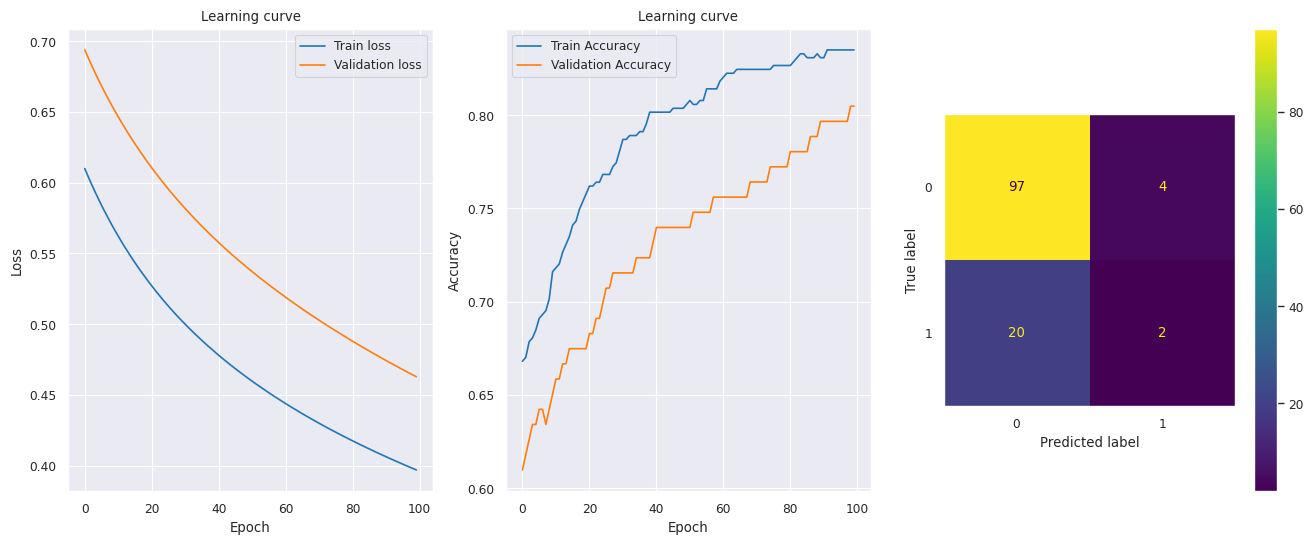

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

# Encode categorical features
le = LabelEncoder()
X_train['EJ'] = le.fit_transform(X_train['EJ'])
X_test['EJ'] = le.transform(X_test['EJ'])

# Impute missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Remove outliers
X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

# Scale features
scaler = PowerTransformer()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# PCA
pca = PCA(n_components=0.85, random_state=random_state)
X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

# Neural Network Architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile Neural Network
opt = SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Neural Network
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test, y_test))

# Evaluate Neural Network
y_pred = model.predict(X_test)
score = balanced_logloss(y_test, y_pred)
print(f'Balanced Log Loss score: {score}')
accuracy = accuracy_score(y_test, np.where(y_pred > 0.5, 1, 0))
print(f'Accuracy: {accuracy}')

# Plot learning curves
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

plt.subplot(131)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot confusion matrix
cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1, 0))
ax = plt.subplot(133)
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.grid(False)
plt.show()


4/4 [==============================] - 0s 2ms/step
Balanced Log Loss score: 8.583655982029324
Accuracy: 0.17886178861788618


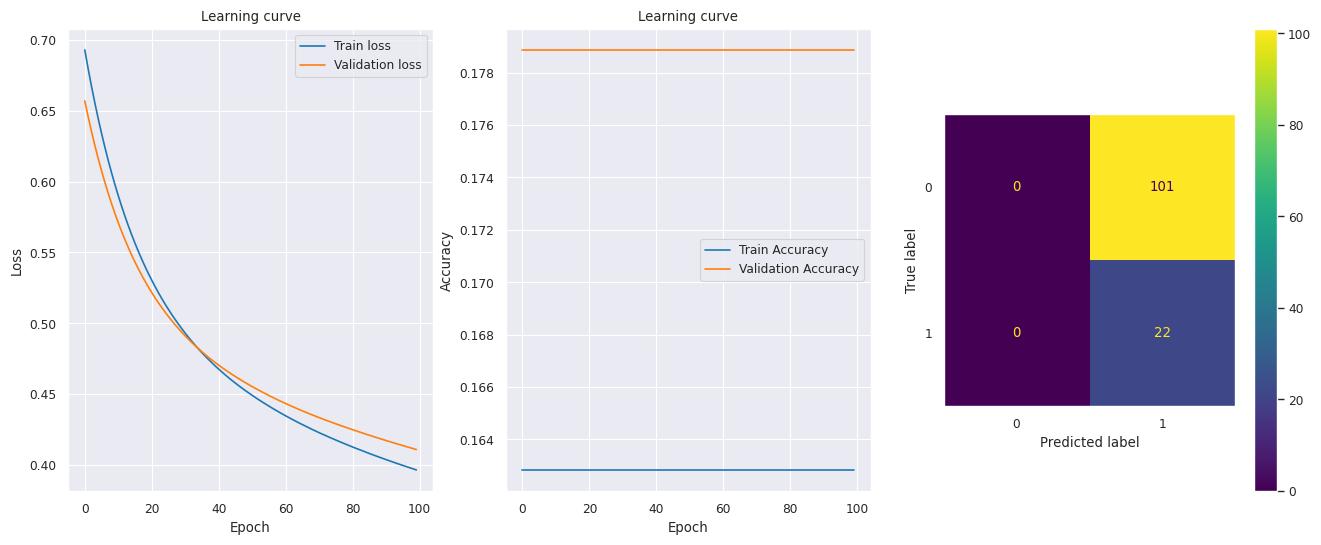

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

# Encode categorical features
le = LabelEncoder()
X_train['EJ'] = le.fit_transform(X_train['EJ'])
X_test['EJ'] = le.transform(X_test['EJ'])

# Impute missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Remove outliers
X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

# Scale features
scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.85, random_state=random_state)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Neural Network Architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile Neural Network
opt = SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Neural Network
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test, y_test))

# Evaluate Neural Network
y_pred = model.predict(X_test)
score = balanced_logloss(y_test, y_pred)
print(f'Balanced Log Loss score: {score}')
accuracy = accuracy_score(y_test, np.where(y_pred > 0.5, 1, 0))
print(f'Accuracy: {accuracy}')

# Plot learning curves
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

plt.subplot(131)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot confusion matrix
cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1, 0))
ax = plt.subplot(133)
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.grid(False)
plt.show()


In [123]:
y_pred[:5]

array([[0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994]], dtype=float32)

In [124]:
test_scaled = scaler.transform(test)
test_pca = pca.transform(test_scaled)
test_pred = model.predict(test_pca, verbose=0)
test_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

### Split Train set into 5 K-Folds to balance classes 

In [45]:
class ImbalancedBinaryCVSplit:
    def __init__(self, X, y, test_size = 0.1, random_state = 42):
        # Define imbalanced classes
        y_cls_min = y.value_counts(ascending=True).index[0]
        y_cls_max = y.value_counts(ascending=True).index[-1]
        
        # Split Train / Test for CV
        X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=test_size, 
                                                                  random_state=random_state, stratify=y)

        # Separate classes for balanced cross validation
        y_train_min = y_train_cv[y_train_cv == y_cls_min]
        y_train_max = y_train_cv[y_train_cv == y_cls_max]
        X_train_min = X_train_cv.loc[y_train_min.index]
        X_train_max = X_train_cv.loc[y_train_max.index]
        
        self.y_train_max = y_train_max
        self.y_train_min = y_train_min
        self.X_train_max = X_train_max
        self.X_train_min = X_train_min
        self.X_test = X_test
        self.y_test = y_test
        
    def split(self):
        # Calculate number of splits needed to use all data
        n_splits = ceil(len(self.y_train_max) / len(self.y_train_min))

        # Chech if all observations of max class was used
        list_max = list(self.y_train_max.index)
        
        # Split balanced train sets
        list_splits = list_max.copy()
        random.shuffle(list_splits)
        
        # Return dict of splits
        splits = {}

        for split in range(n_splits):
            # Include new random observations for last fold
            if len(list_splits) < len(self.y_train_min):
                diff = len(self.y_train_min) - len(list_splits)
                list_splits.extend(random.sample(list(set(self.y_train_max.index) - set(list_splits)), diff))

            # Use elements from list of 0's and remove than
            idx = list_splits[:len(self.y_train_min)]
            del list_splits[:len(self.y_train_min)]

            #Prepare train set
            X_t_s_max, y_t_s_max = self.X_train_max.loc[idx], self.y_train_max.loc[idx]

            # Add imbalanced class
            X_t_s, y_t_s = pd.concat([X_t_s_max, self.X_train_min]), pd.concat([y_t_s_max, self.y_train_min])

            # Shuffle train set
            X_train, y_train = shuffle(X_t_s, y_t_s)
            
            # Check if train/test sets are not overlapping
            assert len(set(y_train.index) & set(self.y_test.index)) == 0
            
            # Add to list
            splits[split] = (X_train, self.X_test, y_train, self.y_test)
            
            # Remove used max from list
            for i in y_train.index:
                if i in list_max:
                    list_max.remove(i)
            
        self.n_splits = n_splits
        self.split_test_size = len(self.y_test) / (len(y_train) + len(self.y_test))
        self.all_max_used = len(list_max) == 0

        return iter(splits.items())

In [46]:
icv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)
for fold, (X_train, X_test, y_train, y_test) in icv.split():
    print(f'+++ FOLD {fold} +++')
    print('X_train size:', len(X_train))
    print('X_test size:', len(X_test))
    print('y_train size:', len(y_train))
    print('y_tests size:', len(y_test))
    print('Balanced:', len(y_train[y_train == 0]) == len(y_train[y_train == 1]))
    
print('N_splits:', icv.n_splits)
print('Split Test Size:', icv.split_test_size)
print('All Max values Used:', icv.all_max_used)
    

+++ FOLD 0 +++
X_train size: 192
X_test size: 62
y_train size: 192
y_tests size: 62
Balanced: True
+++ FOLD 1 +++
X_train size: 192
X_test size: 62
y_train size: 192
y_tests size: 62
Balanced: True
+++ FOLD 2 +++
X_train size: 192
X_test size: 62
y_train size: 192
y_tests size: 62
Balanced: True
+++ FOLD 3 +++
X_train size: 192
X_test size: 62
y_train size: 192
y_tests size: 62
Balanced: True
+++ FOLD 4 +++
X_train size: 192
X_test size: 62
y_train size: 192
y_tests size: 62
Balanced: True
N_splits: 5
Split Test Size: 0.2440944881889764
All Max values Used: True


In [ ]:
class DataPrep:
    def __init__(self):
        pass
        # Encode categorical features
    le = LabelEncoder()
    X_train['EJ'] = le.fit_transform(X_train['EJ'])
    X_test_fold['EJ'] = le.transform(X_test_fold['EJ'])

    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(knn_imputer.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = PowerTransformer()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # PCA
    pca = PCA(n_components=0.85, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test_fold = pd.DataFrame(pca.transform(X_test_fold), index=X_test_fold.index)

In [ ]:
class NNModel:
    def __init__(self):
        pass
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test_fold, y_test_fold))

        # Evaluate Initializations
        y_pred = model.predict(X_test_fold, verbose=0)
        score = balanced_logloss(y_test_fold, y_pred)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score}')

        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_pred = init_best_model.predict(X_test_fold, verbose=0)
    score = balanced_logloss(y_test_fold, y_pred)
    print(f'Fold {fold} Balanced Log Loss: {score}')
    accuracy = accuracy_score(y_test_fold, np.where(y_pred > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    y_pred = np.where(y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}')

Fold 0 Init 0 Balanced Log Loss: 0.38034122473826365
Fold 0 Init 1 Balanced Log Loss: 0.31996813288756776
Fold 0 Init 2 Balanced Log Loss: 0.3075771748454177
Fold 0 Init 3 Balanced Log Loss: 0.4669645145668515
Fold 0 Init 4 Balanced Log Loss: 0.4090899436347951
Fold 0 Balanced Log Loss: 0.3075771748454177
Fold 0 Accuracy: 0.8604651162790697


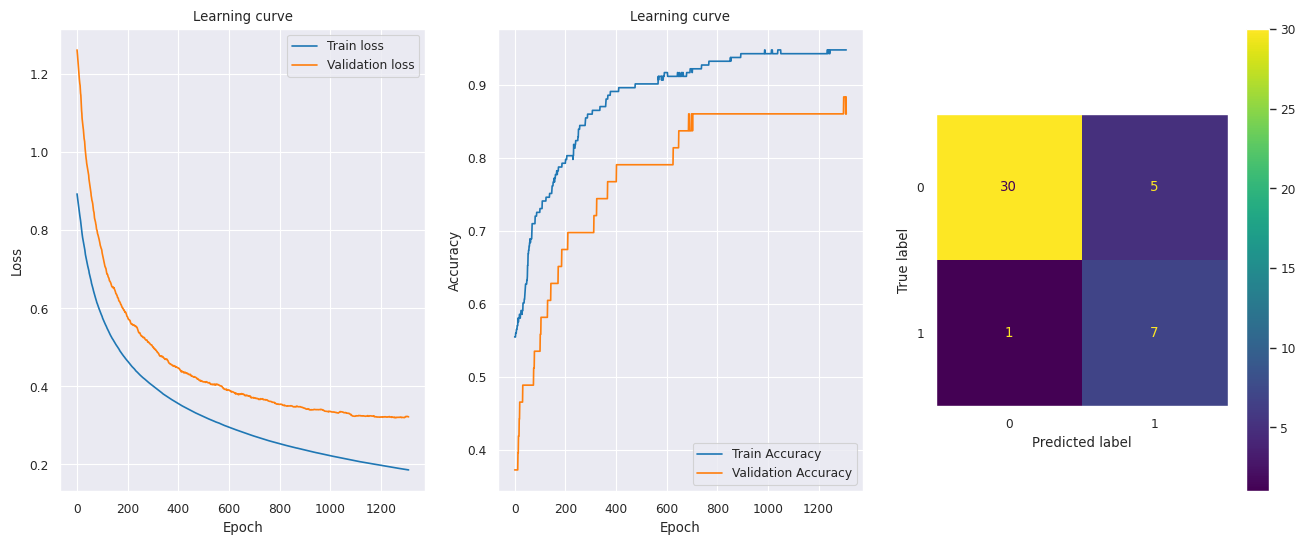

Fold 1 Init 0 Balanced Log Loss: 0.20600984302072903
Fold 1 Init 1 Balanced Log Loss: 0.27138949834375775
Fold 1 Init 2 Balanced Log Loss: 0.2690772119976048
Fold 1 Init 3 Balanced Log Loss: 0.17398731495715244
Fold 1 Init 4 Balanced Log Loss: 0.2514181972938656
Fold 1 Balanced Log Loss: 0.17398731495715244
Fold 1 Accuracy: 0.9302325581395349


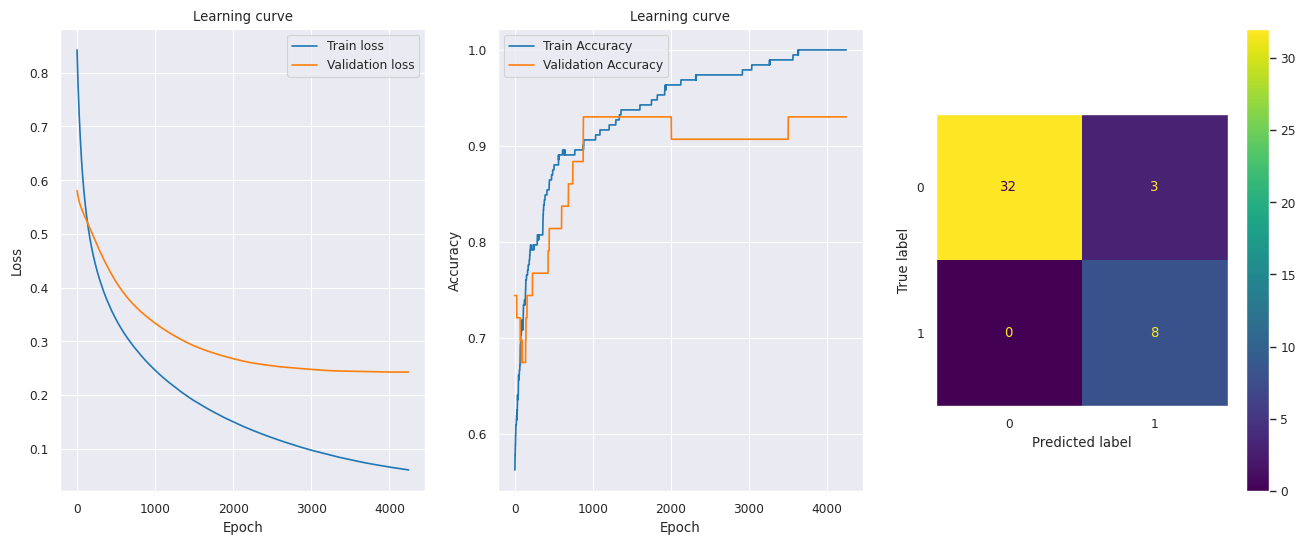

Fold 2 Init 0 Balanced Log Loss: 0.314825880673847
Fold 2 Init 1 Balanced Log Loss: 0.4201632115341324
Fold 2 Init 2 Balanced Log Loss: 0.2569780206780966
Fold 2 Init 3 Balanced Log Loss: 0.2726600216040554
Fold 2 Init 4 Balanced Log Loss: 0.3249759158256763
Fold 2 Balanced Log Loss: 0.2569780206780966
Fold 2 Accuracy: 0.8372093023255814


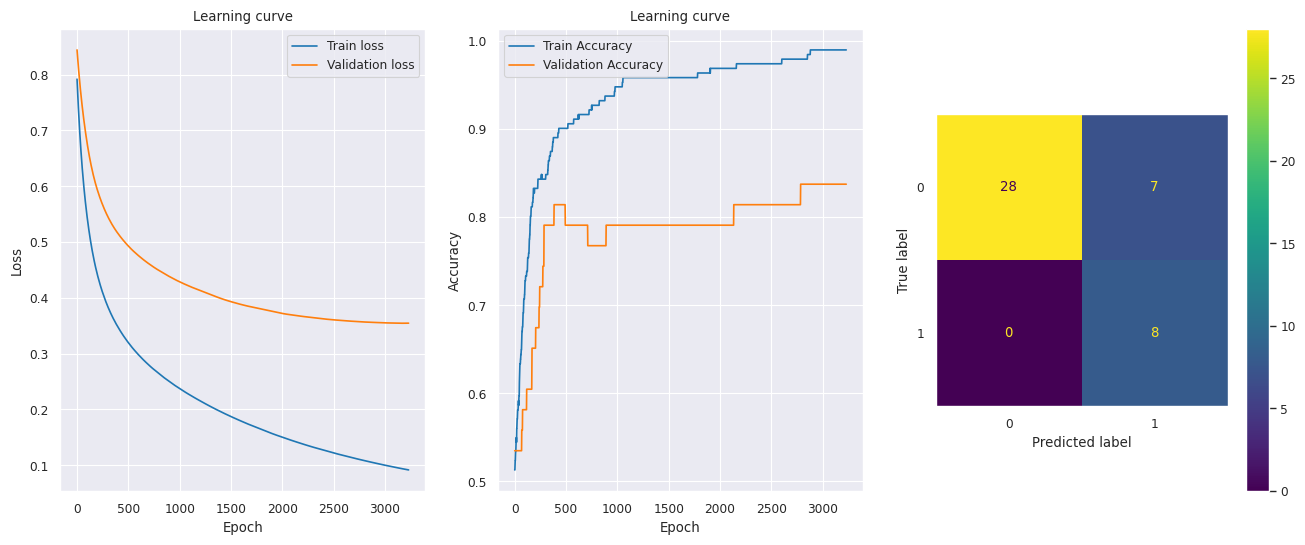

Fold 3 Init 0 Balanced Log Loss: 0.5103920865072203
Fold 3 Init 1 Balanced Log Loss: 0.7187261687857764
Fold 3 Init 2 Balanced Log Loss: 0.3730231486393937
Fold 4 Init 1 Balanced Log Loss: 0.3019524875928515
Fold 4 Init 2 Balanced Log Loss: 0.30797728382084255
Fold 4 Init 3 Balanced Log Loss: 0.3213431051300306
Fold 4 Init 4 Balanced Log Loss: 0.32526555370007243
Fold 4 Balanced Log Loss: 0.3019524875928515
Fold 4 Accuracy: 0.813953488372093


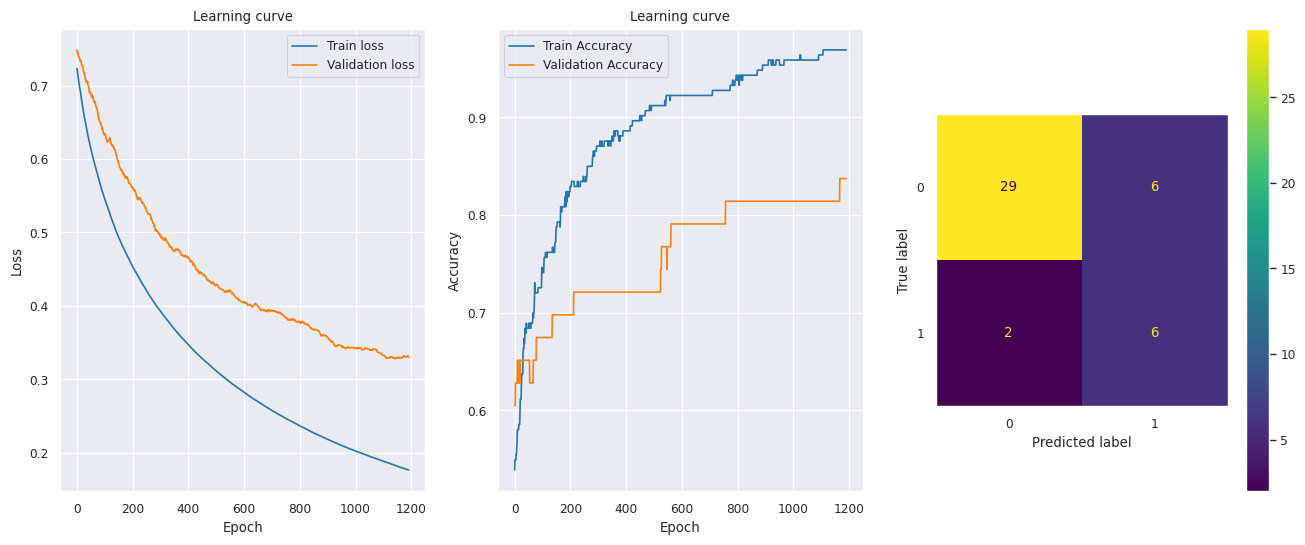

Best Fold: 1
Best Balanced Log Loss: 0.17398731495715244


In [107]:
cv = ShuffleSplit(n_splits=5, train_size=0.21, random_state=random_state)

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.07, random_state=random_state, stratify=y)

# Separate classes for balanced cross validation
y_train_0 = y_train_cv[y_train_cv == 0]
y_train_1 = y_train_cv[y_train_cv == 1]
X_train_0 = X_train_cv.loc[y_train_0.index]
X_train_1 = X_train_cv.loc[y_train_1.index]

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (train_i, val_i) in enumerate(cv.split(X_train_0, y_train_0)):
    # Check if folds are not overlapping
    assert len(set(train_i) & set(val_i)) == 0

    # Copy test set for each fold
    X_test_fold, y_test_fold = X_test.copy(), y_test.copy()

    # Prepare train set
    X_train, y_train = X_train_0.iloc[train_i], y_train_0.iloc[train_i]

    # Add class 1 to train set
    X_train, y_train = pd.concat([X_train, X_train_1]), pd.concat([y_train, y_train_1])

    # Shuffle train set
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # Encode categorical features
    le = LabelEncoder()
    X_train['EJ'] = le.fit_transform(X_train['EJ'])
    X_test_fold['EJ'] = le.transform(X_test_fold['EJ'])

    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(knn_imputer.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = PowerTransformer()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # PCA
    pca = PCA(n_components=0.85, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test_fold = pd.DataFrame(pca.transform(X_test_fold), index=X_test_fold.index)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test_fold, y_test_fold))

        # Evaluate Initializations
        y_pred = model.predict(X_test_fold, verbose=0)
        score = balanced_logloss(y_test_fold, y_pred)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score}')

        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_pred = init_best_model.predict(X_test_fold, verbose=0)
    score = balanced_logloss(y_test_fold, y_pred)
    print(f'Fold {fold} Balanced Log Loss: {score}')
    accuracy = accuracy_score(y_test_fold, np.where(y_pred > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    y_pred = np.where(y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}')

Fold 0 Init 0 Balanced Log Loss: 0.23891395770529836
Fold 0 Init 1 Balanced Log Loss: 0.2164232562561279
Fold 0 Init 2 Balanced Log Loss: 0.19254056471366632
Fold 0 Init 3 Balanced Log Loss: 0.29020575802511667
Fold 0 Init 4 Balanced Log Loss: 0.2587923759862979
Fold 0 Balanced Log Loss: 0.19254056471366632
Fold 0 Accuracy: 0.8548387096774194


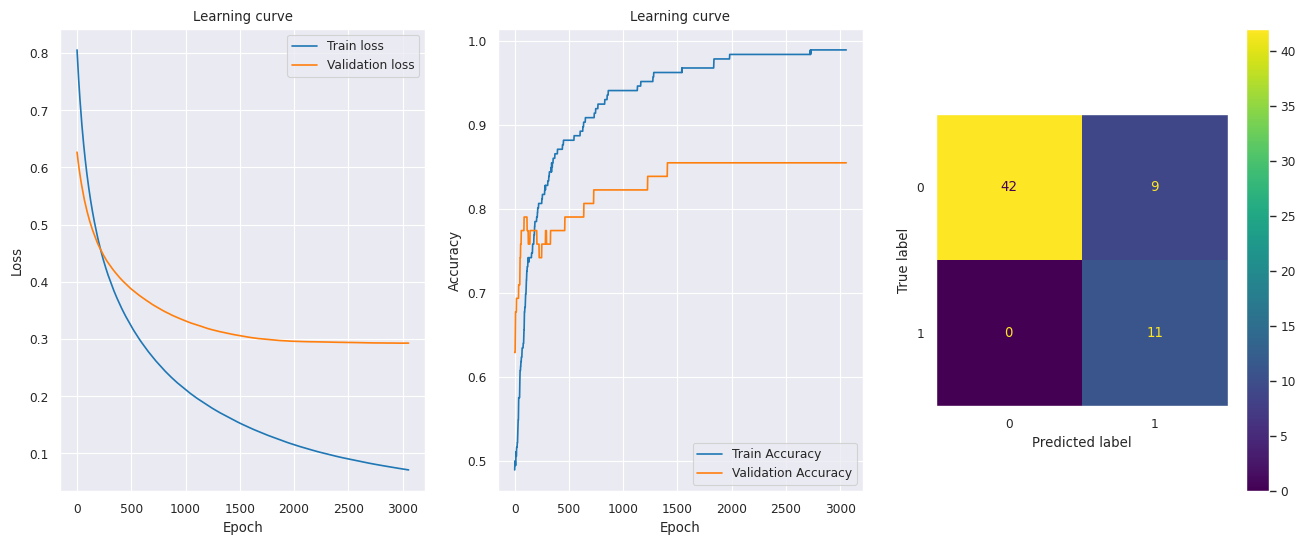

Fold 1 Init 0 Balanced Log Loss: 0.296821933127589
Fold 1 Init 1 Balanced Log Loss: 0.21746006746452265
Fold 1 Init 2 Balanced Log Loss: 0.2591825894572118
Fold 1 Init 3 Balanced Log Loss: 0.2379719656076591
Fold 1 Init 4 Balanced Log Loss: 0.2901041071723778
Fold 1 Balanced Log Loss: 0.21746006746452265
Fold 1 Accuracy: 0.9032258064516129


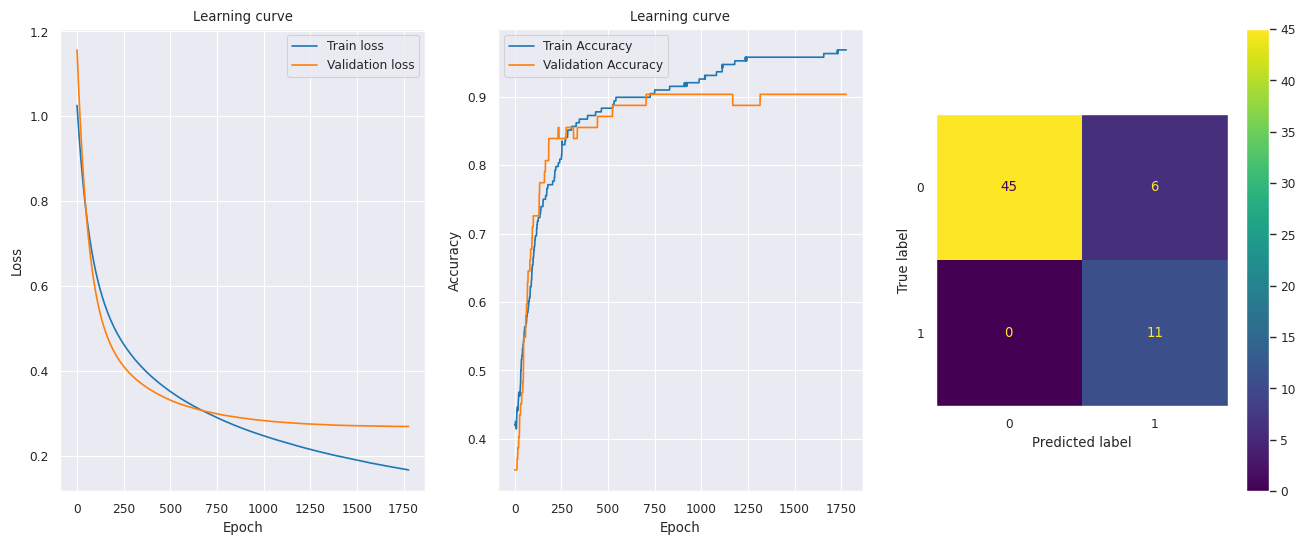

Fold 2 Init 0 Balanced Log Loss: 0.2846602232232738
Fold 2 Init 1 Balanced Log Loss: 0.24161866972066484
Fold 2 Init 2 Balanced Log Loss: 0.22586302729858893
Fold 2 Init 3 Balanced Log Loss: 0.2527089210355998
Fold 2 Init 4 Balanced Log Loss: 0.2843314175778413
Fold 2 Balanced Log Loss: 0.22586302729858893
Fold 2 Accuracy: 0.9193548387096774


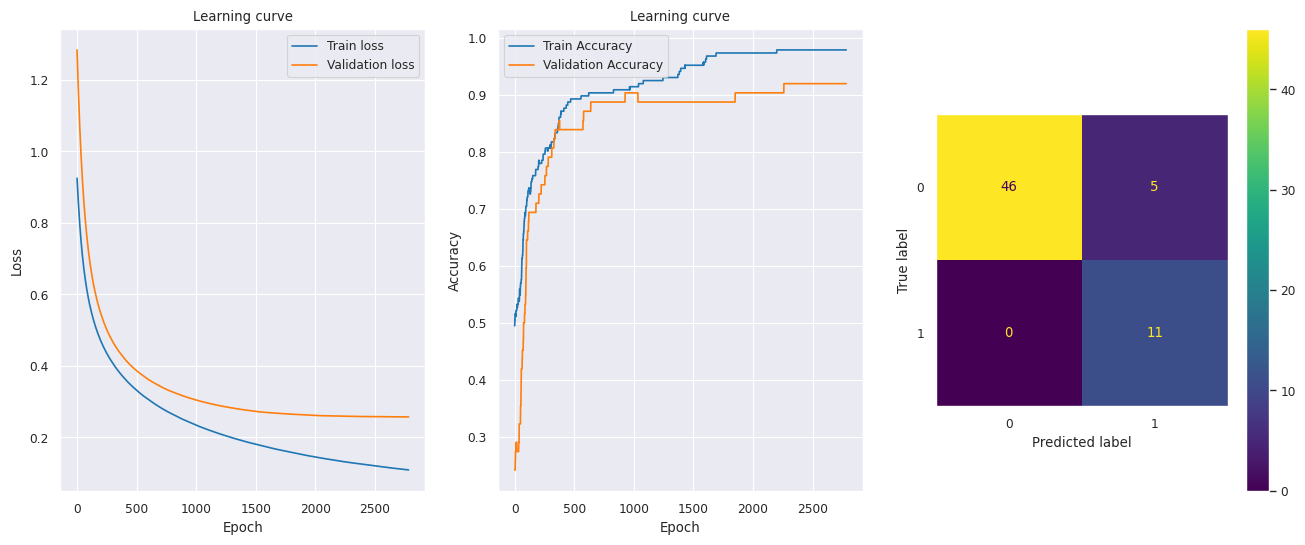

Fold 3 Init 0 Balanced Log Loss: 0.2027628740781297
Fold 3 Init 1 Balanced Log Loss: 0.18881978773088073
Fold 3 Init 2 Balanced Log Loss: 0.23178020013222778
Fold 3 Init 4 Balanced Log Loss: 0.18458811383122034
Fold 3 Balanced Log Loss: 0.15310260238745332
Fold 3 Accuracy: 0.9032258064516129


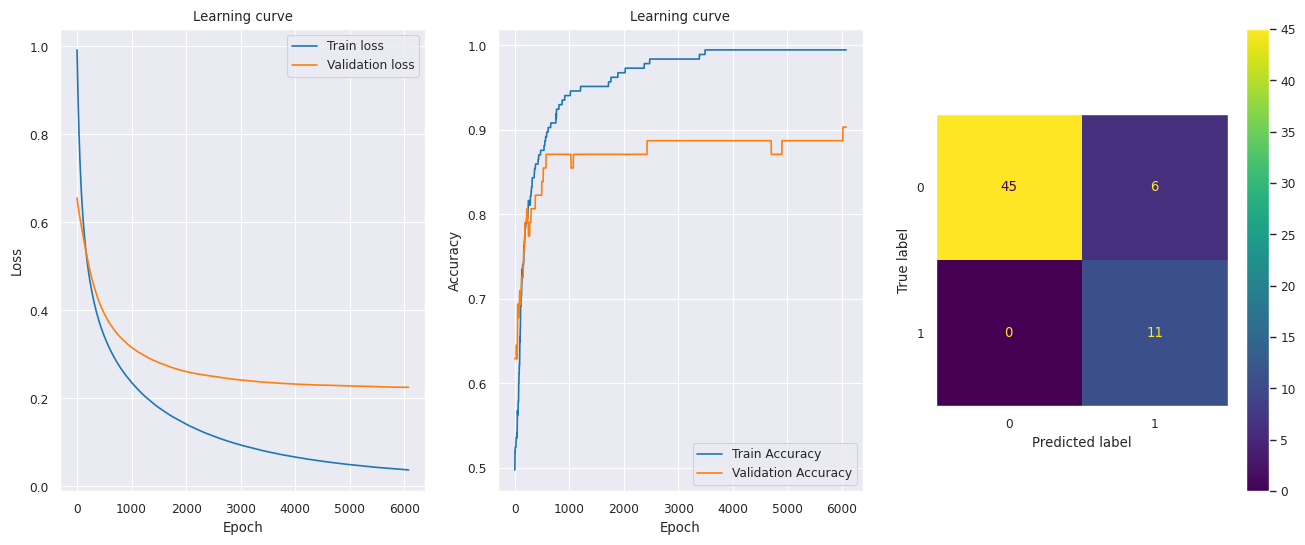

Fold 4 Init 0 Balanced Log Loss: 0.2339266629457667
Fold 4 Init 1 Balanced Log Loss: 0.21741366923760552
Fold 4 Init 2 Balanced Log Loss: 0.17182234478203443
Fold 4 Init 3 Balanced Log Loss: 0.20524040703321103
Fold 4 Init 4 Balanced Log Loss: 0.20475396134106194
Fold 4 Balanced Log Loss: 0.17182234478203443
Fold 4 Accuracy: 0.9193548387096774


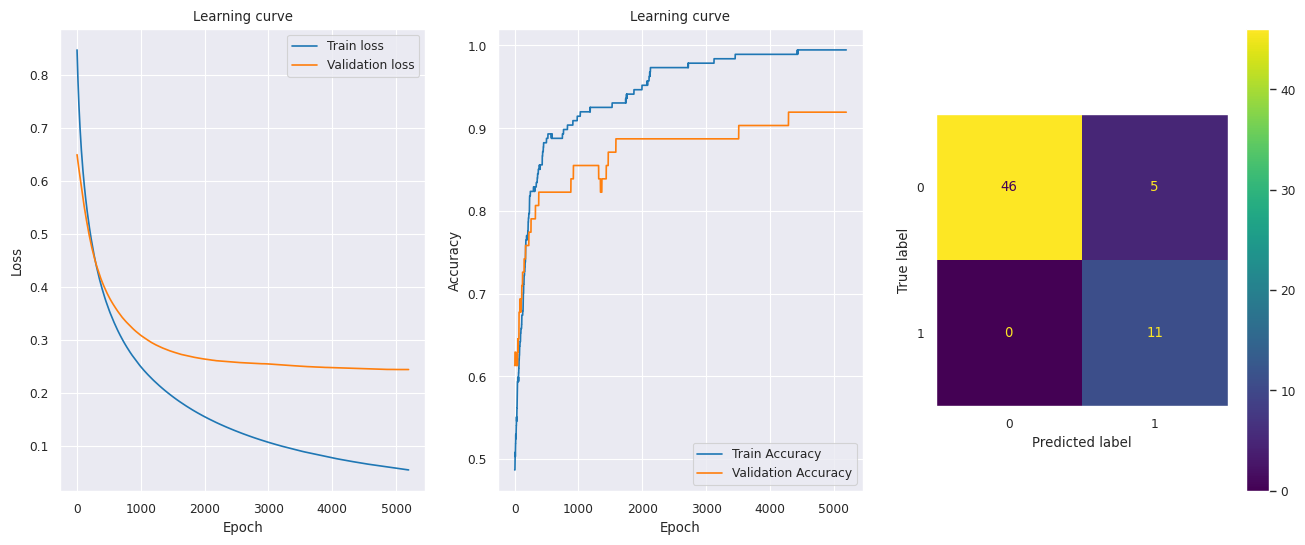

Best Fold: 3
Best Balanced Log Loss: 0.15310260238745332


In [82]:
# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = PowerTransformer()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=0.85, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_pred = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_pred)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score}')

        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_pred = init_best_model.predict(X_test, verbose=0)
    score = balanced_logloss(y_test, y_pred)
    print(f'Fold {fold} Balanced Log Loss: {score}')
    accuracy = accuracy_score(y_test, np.where(y_pred > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    y_pred = np.where(y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}')

## Evaluation

Fold 0 Init 0 Balanced Log Loss: 0.2608
Fold 0 Init 1 Balanced Log Loss: 0.2416
Fold 0 Init 2 Balanced Log Loss: 0.1992
Fold 0 Init 3 Balanced Log Loss: 0.2515
Fold 0 Init 4 Balanced Log Loss: 0.2416
Fold 0 Balanced Log Loss: 0.1992
Fold 0 Accuracy: 0.8548387096774194


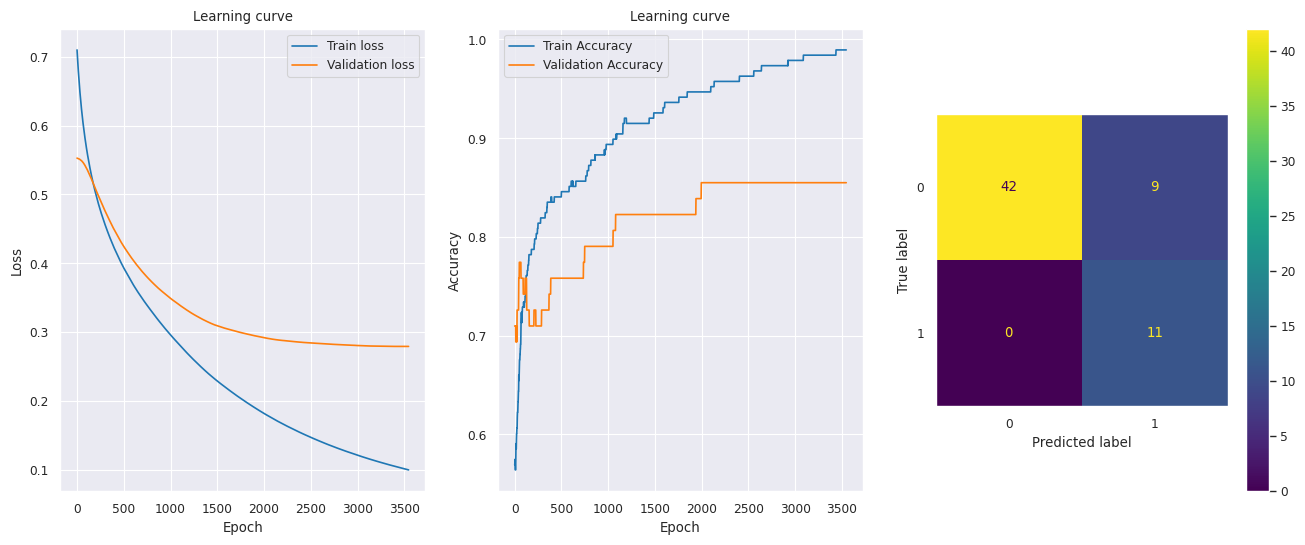

Fold 1 Init 0 Balanced Log Loss: 0.1371
Fold 1 Init 1 Balanced Log Loss: 0.1620
Fold 1 Init 2 Balanced Log Loss: 0.2598
Fold 1 Init 3 Balanced Log Loss: 0.1897
Fold 1 Init 4 Balanced Log Loss: 0.1871
Fold 1 Balanced Log Loss: 0.1371
Fold 1 Accuracy: 0.9193548387096774


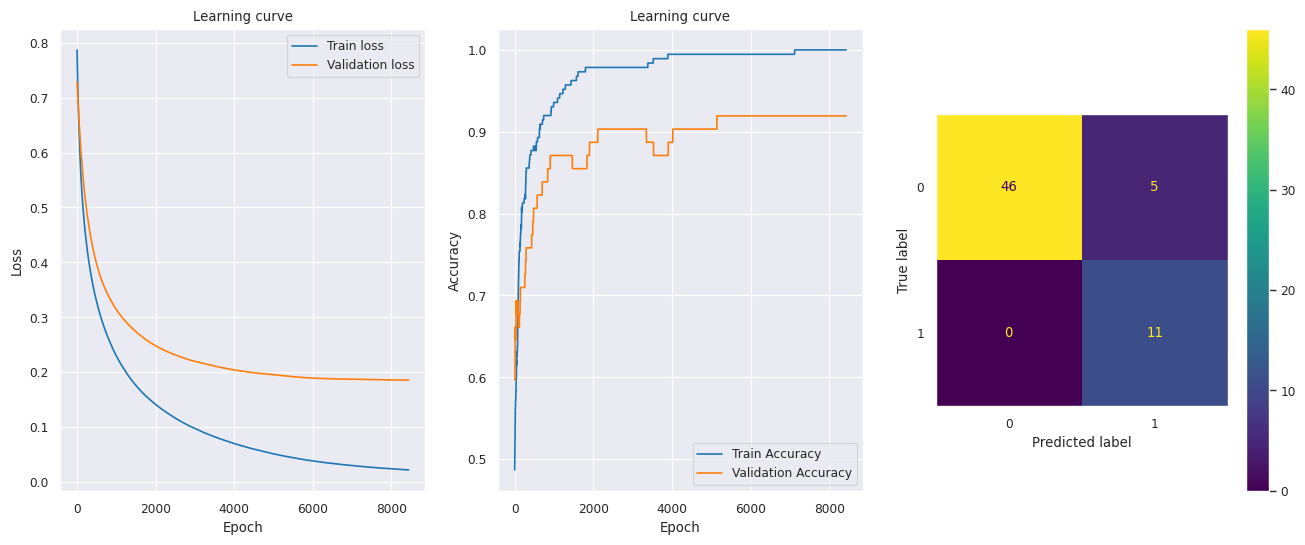

Fold 2 Init 0 Balanced Log Loss: 0.2306
Fold 2 Init 1 Balanced Log Loss: 0.2457
Fold 2 Init 2 Balanced Log Loss: 0.2977
Fold 2 Init 3 Balanced Log Loss: 0.2800
Fold 2 Init 4 Balanced Log Loss: 0.2602
Fold 2 Balanced Log Loss: 0.2306
Fold 2 Accuracy: 0.8870967741935484


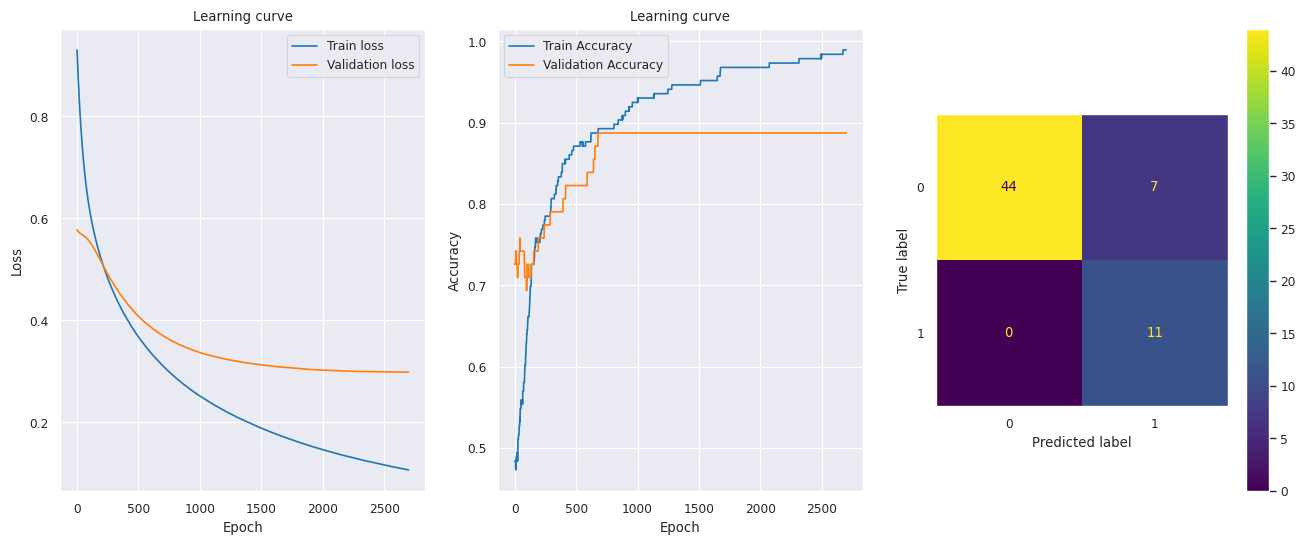

Fold 3 Init 0 Balanced Log Loss: 0.2061
Fold 3 Init 1 Balanced Log Loss: 0.2313
Fold 3 Init 2 Balanced Log Loss: 0.1889
Fold 3 Init 3 Balanced Log Loss: 0.2160
Fold 3 Init 4 Balanced Log Loss: 0.2555
Fold 3 Balanced Log Loss: 0.1889
Fold 3 Accuracy: 0.8709677419354839


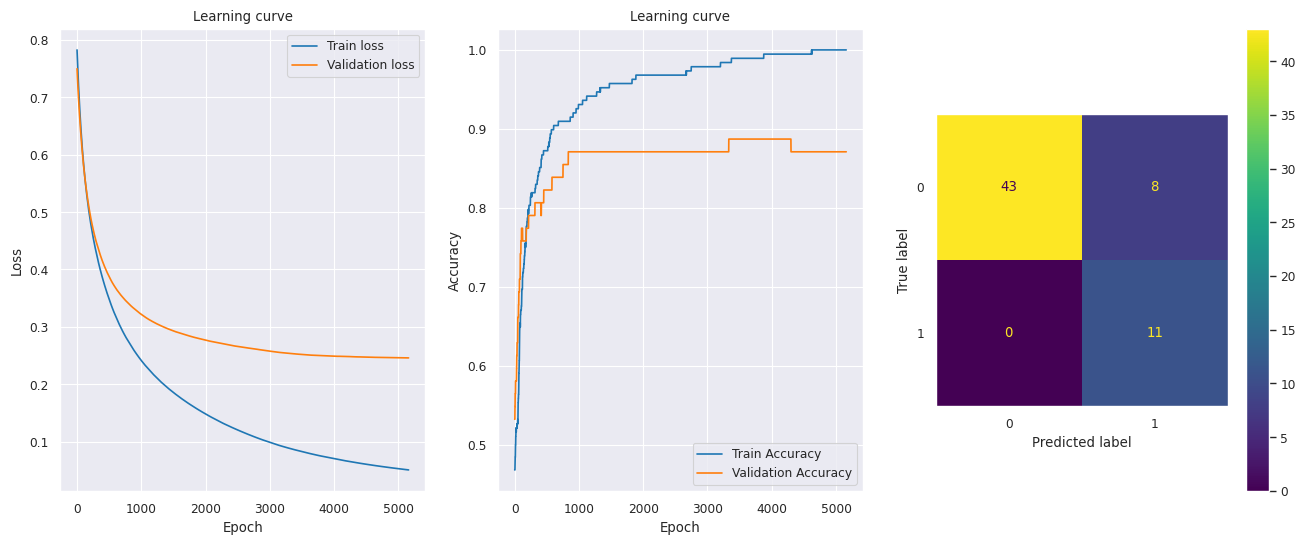

Fold 4 Init 0 Balanced Log Loss: 0.3488
Fold 4 Init 1 Balanced Log Loss: 0.3105
Fold 4 Init 2 Balanced Log Loss: 0.3280
Fold 4 Init 3 Balanced Log Loss: 0.3237
Fold 4 Init 4 Balanced Log Loss: 0.2126
Fold 4 Balanced Log Loss: 0.2126
Fold 4 Accuracy: 0.8709677419354839


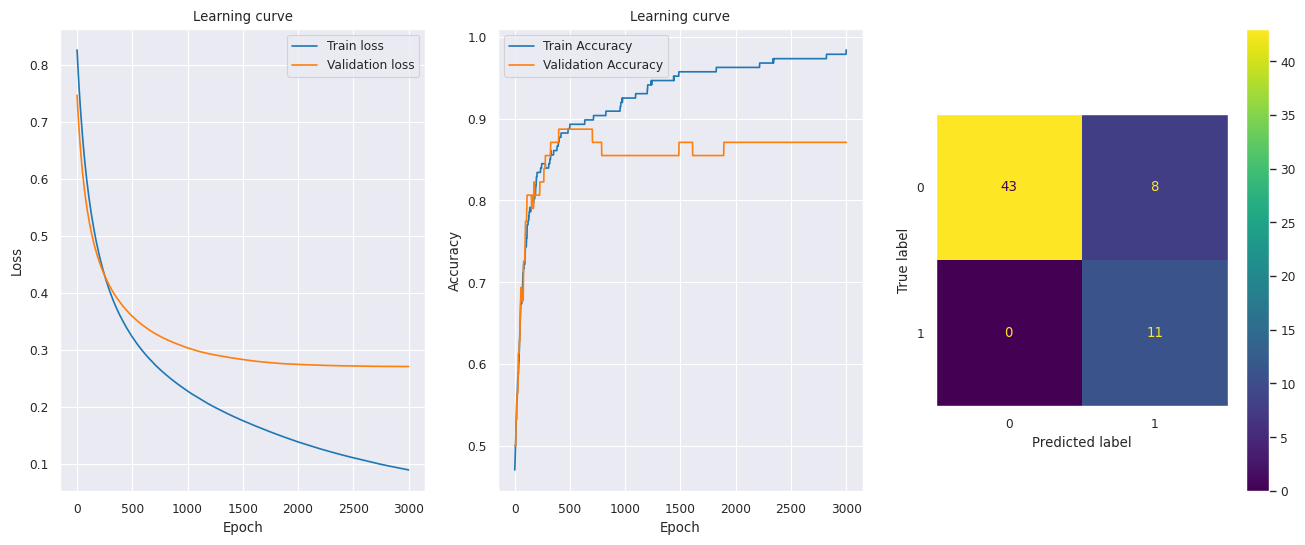

Best Fold: 1
Best Balanced Log Loss: 0.13708889917153635

CPU times: user 58min 54s, sys: 3min 37s, total: 1h 2min 32s
Wall time: 59min 27s


In [50]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = PowerTransformer()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_pred = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_pred)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_pred = init_best_model.predict(X_test, verbose=0)
    score = balanced_logloss(y_test, y_pred)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, np.where(y_pred > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1, 0))
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

In [51]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
4,1.912673,-1.064157,0.010144,1.558021,1.265949,2.052113,1.724801,0.029584,1.628594,1.215574,...,1.159446,0.704568,-1.435676,2.285262,-0.010780,0.621227,-0.165920,-0.227430,2.072971,-0.315807
467,0.238083,3.480403,2.838394,-0.118862,-0.769871,0.269828,-1.480460,2.168845,-0.342606,-0.482943,...,-0.398144,0.318820,-0.175431,1.461132,-1.168153,0.188752,0.189518,0.486329,1.885955,1.609162
94,-2.393955,-0.093259,-1.265786,1.211315,-1.508775,2.997603,-1.474089,0.942480,0.395145,-0.359876,...,0.184273,-0.566216,-0.037344,0.471867,0.201756,0.655228,-0.323359,0.310347,0.251419,0.311459
83,-3.005435,-0.223086,-2.865993,-0.999979,-1.196566,0.141739,0.033651,0.201163,1.045851,-1.785037,...,0.837864,-0.273505,-0.840594,-0.790211,0.021704,0.547684,-0.143475,0.609392,-0.344444,-0.008011
529,-0.724056,-1.475129,1.186725,2.158444,-3.528834,0.546817,-0.570108,0.012082,0.129932,0.860728,...,-1.854051,0.846799,-0.016959,-0.582265,-0.184527,-0.653030,1.167220,-1.615734,-0.618348,-0.364935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.886607,-0.362138,-2.079945,-0.101198,-0.426603,-1.789246,-0.920390,1.492300,0.796526,-0.742110,...,-0.768904,-0.187140,0.117460,-0.918957,0.111556,-0.851961,-0.715639,-0.365233,-1.442056,-0.220205
181,1.823710,1.183764,-1.349193,-1.319485,1.722069,0.030160,-0.411207,0.843282,-0.268412,0.002104,...,0.449401,-0.147874,0.912151,-0.260980,-0.465333,0.121337,-0.352285,-0.177643,0.340094,-1.240763
463,1.213549,-1.855784,0.025921,-0.817919,-0.625000,-0.017414,0.257054,-0.729976,1.526704,-0.572615,...,-0.316628,-1.406251,-1.289826,-0.174252,1.528734,0.079083,0.532185,1.575678,1.019974,0.846217
25,-0.152316,1.139744,-3.121811,3.102597,-2.251318,2.999448,-2.271858,-0.390447,-0.888996,-0.546878,...,-0.505791,1.447603,0.466967,-0.862054,0.170868,1.122690,1.078749,-0.210435,0.141712,-0.928225


In [52]:
test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': PowerTransformer(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x7f5f60182fe0>}

In [109]:
test_scaled = pd.DataFrame(cv_data[best_fold]['scaler'].transform(test), columns=test.columns, index=test.index)
test_pca = pd.DataFrame(cv_data[best_fold]['pca'].transform(test_scaled), index=test_scaled.index)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)